# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [ ]:
# pip install -r requirements.txt

In [5]:
# pip list --format=freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# 폰트 설정 
# 폰트는 본인 컴퓨터에 내장된 폰트로 바꿔서 사용
# applegothic은 mac 
plt.rcParams['font.family'] = 'AppleGothic'

### 데이터 셋 읽어오기

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [7]:
df_train = pd.read_csv('train (1).csv')
df_test = pd.read_csv('submission (1).csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [10]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

In [8]:
# 전처리 할 데이터 통합 및 동일 index 방지
df_all = pd.concat([df_train, df_test.drop('id', axis = 1)], ignore_index = True)
df_all.shape

(64570, 29)

### bant_submit

In [9]:
df_all['bant_submit'].value_counts()

bant_submit
1.00    19131
0.50    17859
0.25    14374
0.75    12226
0.00      980
Name: count, dtype: int64

Text(0.5, 1.0, '하나 이상 적은 고객')

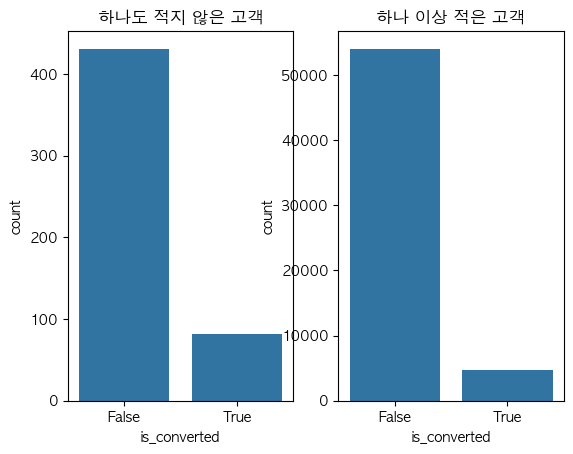

In [10]:
# 하나 이상 적은 고객 <-> 하나도 적지 않은 고객 True 비율 시각화 
# 하나도 적지 않은 고객의 True 비율이 더욱 높으므로 
# 하나도 적지 않은 고객: 1 하나 이상 적은 고객: 0인 변수 생성
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_train[df_train['bant_submit'] == 0], ax = ax[0])
ax[0].set_title('하나도 적지 않은 고객')
sns.countplot(x = 'is_converted', data = df_train[df_train['bant_submit'] != 0], ax = ax[1])
ax[1].set_title('하나 이상 적은 고객')

### com_reg_ver_win_rate

In [12]:
# 중앙값인 0.04를 기준으로 True 비율 확인 
df_all['com_reg_ver_win_rate'].describe()

count    16356.000000
mean         0.092849
std          0.151108
min          0.003788
25%          0.024432
50%          0.049180
75%          0.074949
max          1.000000
Name: com_reg_ver_win_rate, dtype: float64

<Axes: ylabel='count'>

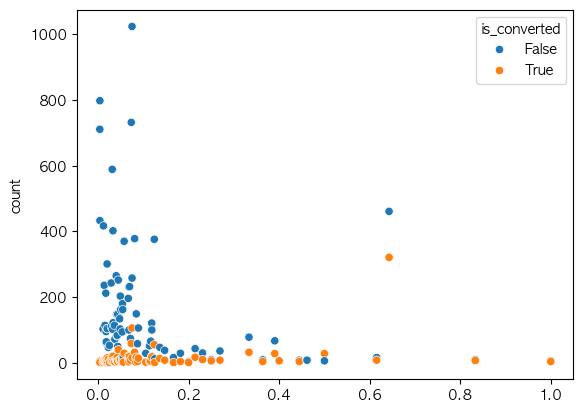

In [13]:
# 0.04 이하로 False가 많고 그 이상으론 True가 많음 
ex = df_all.groupby('com_reg_ver_win_rate')['is_converted'].value_counts()
ex = pd.DataFrame(ex)
index1 = [ex.index[i][0] for i in range(len(ex))]
sns.scatterplot(x = index1, y = 'count', hue = 'is_converted', data = ex)

In [15]:
# 0.04 이하는 0  0.04 초과는 1
df_all['com_reg_count'] = df_all['com_reg_ver_win_rate'].apply(lambda x: 1 if x > 0.04 else 0)
df_all['com_reg_count'].value_counts()

com_reg_count
0    54747
1     9823
Name: count, dtype: int64

Text(0.5, 1.0, '0.04 초과')

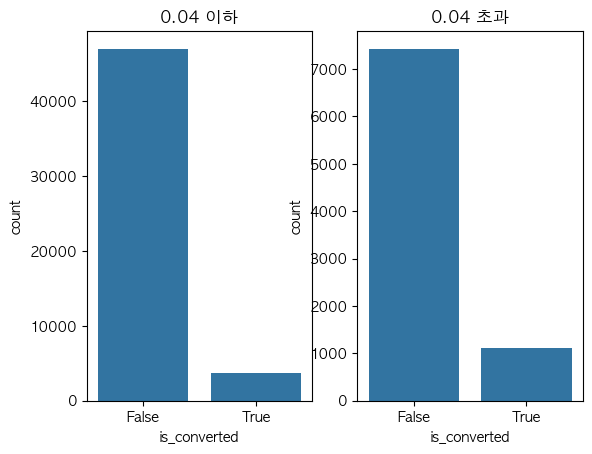

In [16]:
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['com_reg_count'] == 0], ax = ax[0])
ax[0].set_title('0.04 이하')
sns.countplot(x = 'is_converted', data = df_all[df_all['com_reg_count'] == 1], ax = ax[1])
ax[1].set_title('0.04 초과')

### customer_idx

Text(0.5, 1.0, '1번 이하')

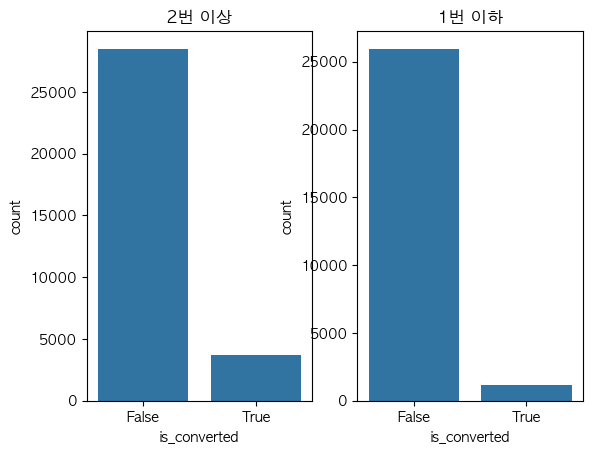

In [17]:
# 2번 이상 문의한 고객은 1 1번 이하로 문의한 고객은 0
idx_count = df_all['customer_idx'].value_counts()
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['customer_idx'].isin(idx_count[idx_count>1].index)], ax = ax[0])
ax[0].set_title('2번 이상')
sns.countplot(x = 'is_converted', data = df_all[df_all['customer_idx'].isin(idx_count[idx_count<=1].index)], ax = ax[1])
ax[1].set_title('1번 이하')

### lead_desc_length

In [18]:
df_all['lead_desc_length'].describe()

count    64570.000000
mean        79.479309
std        132.758693
min          1.000000
25%          7.000000
50%         29.000000
75%         93.000000
max       1264.000000
Name: lead_desc_length, dtype: float64

Text(0.5, 1.0, '0.04 초과')

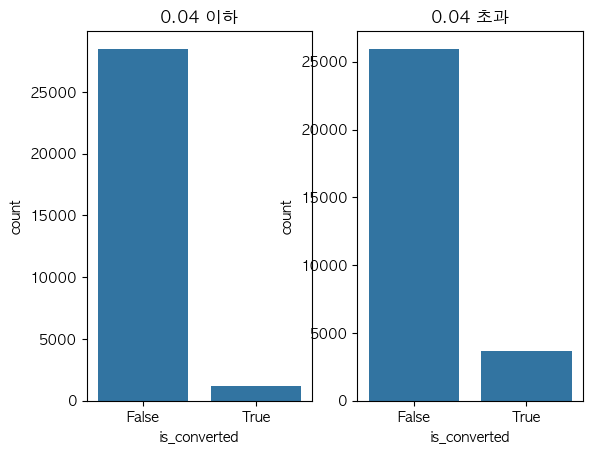

In [33]:
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_desc_length'] <=29], ax = ax[0])
ax[0].set_title('50% 이하')
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_desc_length'] >29], ax = ax[1])
ax[1].set_title('50% 초과')

<Axes: xlabel='lead_desc_length', ylabel='Density'>

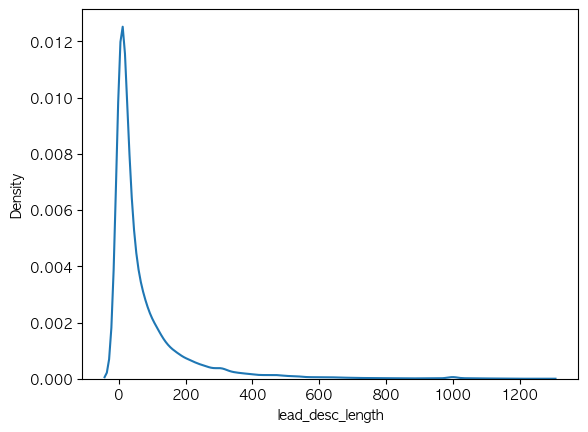

In [19]:
# 비대칭 심함 
sns.kdeplot(df_all['lead_desc_length'])

In [20]:
df_all['lead_desc_length'].skew()

3.593430694287027

In [24]:
# skew 값 0에 가까울수록 대칭
# log 변환 써서 비대칭 완화 
df_log = np.log(df_all['lead_desc_length'])
df_log.skew()


-0.025152528237912666

<Axes: xlabel='lead_desc_length', ylabel='Density'>

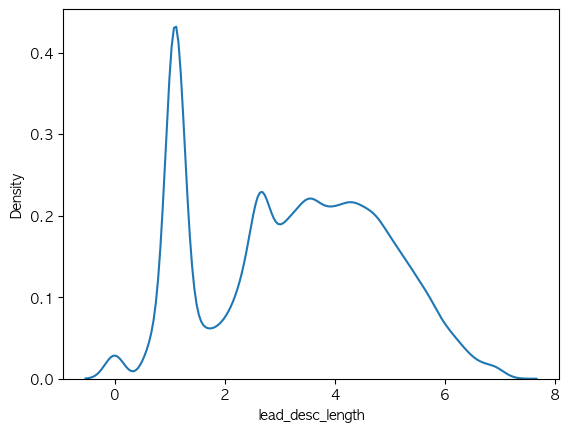

In [25]:
sns.kdeplot(df_log)

In [26]:
df_log.describe()

count    64570.000000
mean         3.269996
std          1.608116
min          0.000000
25%          1.945910
50%          3.367296
75%          4.532599
max          7.142037
Name: lead_desc_length, dtype: float64

In [29]:
df_all['lead_log'] = df_all['lead_desc_length'].apply(lambda x: np.log(x))
df_all['lead_log'].describe()

count    64570.000000
mean         3.269996
std          1.608116
min          0.000000
25%          1.945910
50%          3.367296
75%          4.532599
max          7.142037
Name: lead_log, dtype: float64

Text(0.5, 1.0, '5 이상')

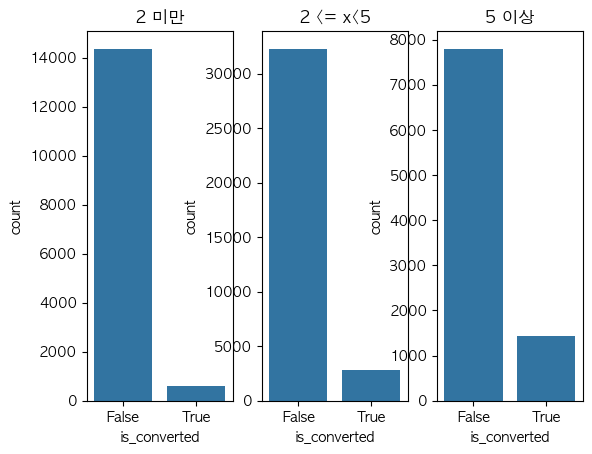

In [73]:
# 길이가 길어질수록 True 비율 높아짐
# density를 기준으로 2 미만, 2<=x<5, 5 초과로 나눠서 True 비율 확인
fig, ax = plt.subplots(1,3)
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] <2], ax = ax[0])
ax[0].set_title('2 미만')
sns.countplot(x = 'is_converted', data = df_all[(df_all['lead_log'] >=2)&(df_all['lead_log']<5)], ax = ax[1])
ax[1].set_title('2 <= x<5')
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] >=5], ax = ax[2])
ax[2].set_title('5 이상')

Text(0.5, 1.0, '50% 초과')

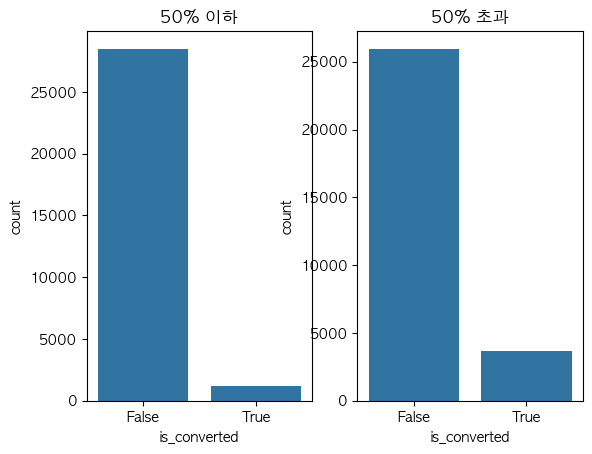

In [69]:
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] <= 3.367296], ax = ax[0])
ax[0].set_title('50% 이하')
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] > 3.367296], ax = ax[1])
ax[1].set_title('50% 초과')

Text(0.5, 1.0, '25% 초과')

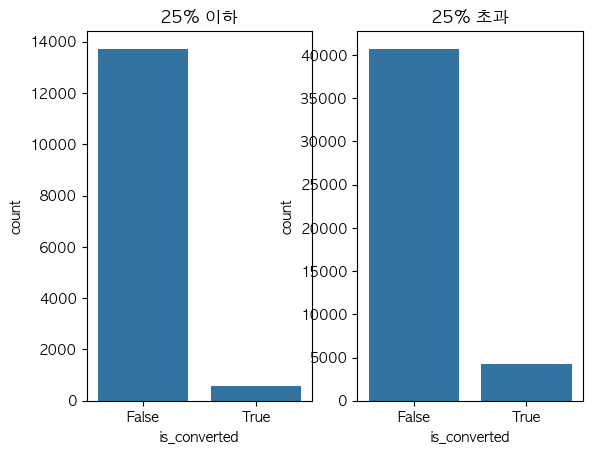

In [71]:
# 2이하에 밀도가 높더라도 길이가 긴 데이터에 True 비율이 더 높음 
# 범주형으로 나눈다면 50%를 기준으로 나누는게 더 유의미해 보임 
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] <= 1.945910], ax = ax[0])
ax[0].set_title('25% 이하')
sns.countplot(x = 'is_converted', data = df_all[df_all['lead_log'] > 1.945910], ax = ax[1])
ax[1].set_title('25% 초과')

### historical_existing_cnt

In [78]:
# 75%와 max 사이 간격이 너무 큼
df_all['historical_existing_cnt'].describe()

count    15031.000000
mean        20.027610
std         48.039031
min          0.000000
25%          1.000000
50%          4.000000
75%         19.000000
max       2219.000000
Name: historical_existing_cnt, dtype: float64

<Axes: xlabel='historical_existing_cnt', ylabel='Density'>

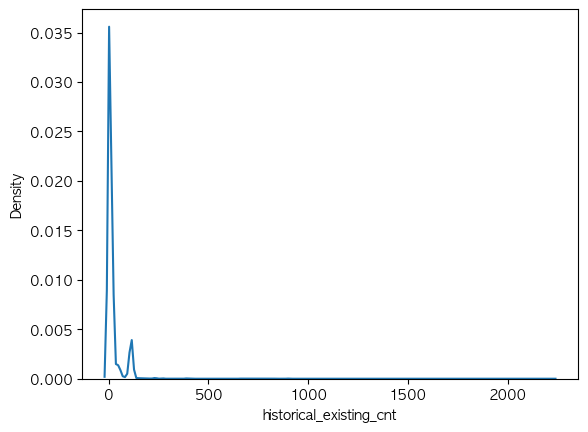

In [90]:
sns.kdeplot(df_all['historical_existing_cnt'])

<Axes: xlabel='historical_existing_cnt', ylabel='historical_existing_cnt'>

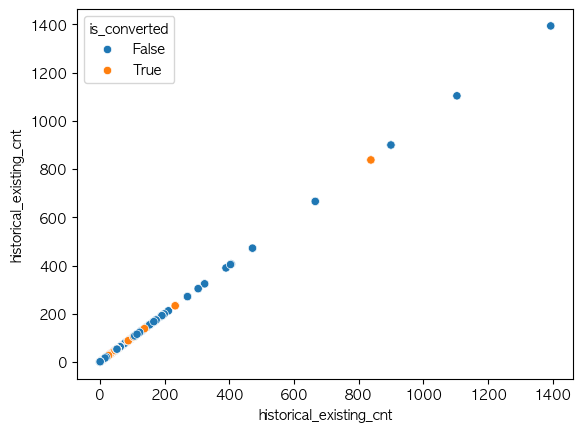

In [81]:
sns.scatterplot(x = 'historical_existing_cnt', y = 'historical_existing_cnt', hue = 'is_converted', data = df_all)

Text(0.5, 1.0, '200 초과')

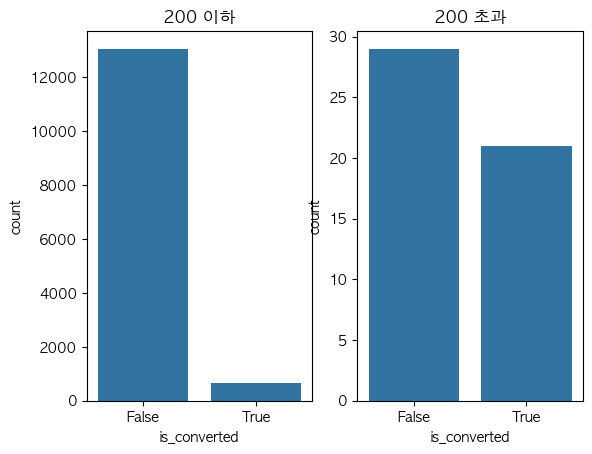

In [93]:
# 밀도가 낮은 200을 기준으로 시각화
# 추후에 더 분석 예정 
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['historical_existing_cnt'] <= 200], ax = ax[0])
ax[0].set_title('200 이하')
sns.countplot(x = 'is_converted', data = df_all[df_all['historical_existing_cnt'] > 200], ax = ax[1])
ax[1].set_title('200 초과')

In [98]:
df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].fillna(0)

In [100]:
# nan값도 0으로 하면서 0의 비율이 높아짐
df_all['historical_existing_cnt'].describe()

count    64570.00000
mean         4.66215
std         24.67431
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max       2219.00000
Name: historical_existing_cnt, dtype: float64

Text(0.5, 1.0, '!=0')

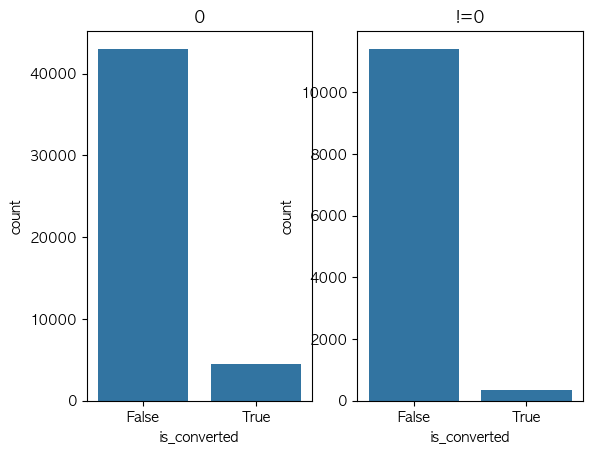

In [104]:
fig, ax = plt.subplots(1,2)
sns.countplot(x = 'is_converted', data = df_all[df_all['historical_existing_cnt'] ==0], ax = ax[0])
ax[0].set_title('0')
sns.countplot(x = 'is_converted', data = df_all[df_all['historical_existing_cnt'] !=0], ax = ax[1])
ax[1].set_title('!=0')

Text(0.5, 1.0, 'smb, 0')

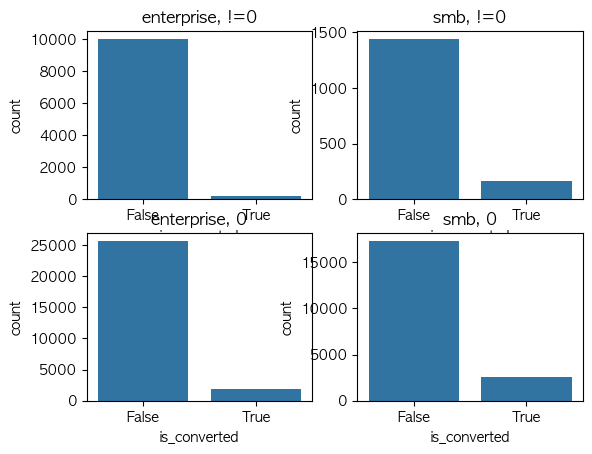

In [105]:
# smb는 비교적 비율이 비슷하지만 enterprise는 1 이상인 경우 True 비율이 매우 낮음 
# enterprise이면서 1 이상인 경우 가중치 주는 변수 생성 
fig, ax = plt.subplots(2,2)

sns.countplot(x = 'is_converted', data = df_all[(df_all['enterprise'] == 'Enterprise')&(df_all['historical_existing_cnt']!=0)], ax = ax[0,0])
ax[0,0].set_title('enterprise, !=0')
sns.countplot(x = 'is_converted', data = df_all[(df_all['enterprise'] == 'SMB')&(df_all['historical_existing_cnt']!=0)], ax = ax[0,1])
ax[0,1].set_title('smb, !=0')
sns.countplot(x = 'is_converted', data = df_all[(df_all['enterprise'] == 'Enterprise')&(df_all['historical_existing_cnt']==0)], ax = ax[1,0])
ax[1,0].set_title('enterprise, 0')
sns.countplot(x = 'is_converted', data = df_all[(df_all['enterprise'] == 'SMB')&(df_all['historical_existing_cnt']==0)], ax = ax[1,1])
ax[1,1].set_title('smb, 0')

### product_category

In [13]:
# product_category
product_dict = {}
product_dict['HVAC/ESS'] = ['control', 'ventilation', 'vrf', 'multi-split', 'single-split', 'chiller', 'heating']
product_dict['commercial display'] = ['oled signage', 'led signage', 'video wall signage', 'interactive signage',
                                       'high brightness signage', 'special signage', 'standard signage', 'hotel tv', 'hospital tv', 'software solution',
                                       'signage care solution', 'webos', 'procentric', 'one quick', 'interactive digital board']
product_dict['it products'] = ['monitor', 'laptop', 'projector', 'cloud device', 'medical display']

def original_category(text):
  for key in product_dict.keys():
    if text in product_dict[key]:
      return key

# site 속 카테고리 기준 original 카테고리 변수 생성
df_all['category'] = df_all['product_category'].apply(original_category)

# ',' 포함한 데이터는 integrated solution으로 solution 카테고리로 처리
df_all.loc[df_all['product_category'].str.contains(',', na = False), 'category'] = 'solution'

# 임시로 nan으로 처리
df_all['category'] = df_all['category'].fillna('nan')

# product_dict로 처리되지 않은 카테고리 확인
df_all[df_all['category'] == 'nan']['product_category'].value_counts()

product_category
etc.                        2220
rac                         1447
lg one:quick series          768
one:quick series             690
teto ou cassete inverter     308
                            ... 
unitario                       1
medical monitor                1
tv 60"                         1
50us660h0sd.bwz                1
notebook                       1
Name: count, Length: 208, dtype: int64

In [14]:
# 카테고리 입력 함수
def category_input(text, input):
  df_all.loc[(df_all['product_category'].str.contains(text, na = False))&(df_all['category'] == 'nan'), 'category'] = input

# 언어 번역
def category_lang(text, input):
  df_all.loc[df_all['product_category'].str.contains(text, na = False), 'product_category'] = input

In [15]:
# teto ou cassete inverter 번역 => 'ceiling or inverter cassette' => hvac/ess
category_lang('teto ou cassete inverter', 'ceiling or inverter cassette')

# rac => residential air conditioner => hvac/ess
category_lang('rac', 'residential air conditioner')

# ar condicionado residencial => residential air conditioner => hvac/ess
category_lang('ar condicionado residencial', 'residential air conditioning')

# outros => others
category_lang('outros', 'others')

# technical support, lg customer care program => support
category_input('technical support', 'support')
category_input('lg customer care program', 'support')

# scroll compressor => compressor/motor
category_input('scroll compressor', 'compressor/motor')

# robots => robot
category_input('robots', 'robot')


# ogrzewanie (pompy ciepła) => heating(heat pumps)
category_lang('ogrzewanie', 'heating(heat pumps)')

# aire acondicionado residencial => residential air conditioning
category_lang('aire acondicionado residencial', 'residential air conditioning')
# led 顯示屏 => led display
category_lang('led 顯示屏', 'led display')
# isıtma => heating
category_lang('isıtma', 'heating')
# lainnya => other
category_lang('lainnya', 'other')
# calefacción => heating
category_lang('calefacción', 'heating')
# 互動式顯示屏 => interactive display
category_lang('互動式顯示屏', 'interactive display')
# 標準顯示屏 => standard display
category_lang('標準顯示屏', 'standard display')
# điều hòa trung tâm vrf => vrf central air conditioner
category_lang('điều hòa trung tâm vrf', 'vrf central air conditioner')
# soğutucu => cooler
category_lang('soğutucu', 'cooler')
# تكييف وتبريد => conditioning and cooling
category_lang('تكييف وتبريد', 'conditioning and cooling')
# 特別顯示屏 => special display
category_lang('特別顯示屏', 'special display')
# מזגנים למקום מגורים => residential air conditioner
category_lang('מזגנים למקום מגורים', 'residential air conditioner')
# เครื่องปรับอากาศเผื่อที่อยู่อาศัย => residential air conditioner
category_lang('เครื่องปรับอากาศเผื่อที่อยู่อาศัย', 'residential air conditioner')
# חימום => heating
category_lang('חימום', 'heating')
# تكييفات => air conditioner
category_lang('تكييفات', 'air conditioner')
# điều hòa cục bộ => local air conditioning
category_lang('điều hòa cục bộ', 'local air conditioning')
# 醫院電視 => hospital tv
category_lang('醫院電視', 'hospital tv')
# 高亮度顯示屏 => high brightness display
category_lang('高亮度顯示屏', 'high brightness display')
# 軟體 => software
category_lang('軟體', 'software')
# פיצול מרובה => multi split
category_lang('פיצול מרובה', 'multi split')
# 酒店電視 => hotel tv
category_lang('酒店電視', 'hotel tv')
# حلول التدفئة => heating solution
category_lang('حلول التدفئة', 'heating solution')
# אחר => other
category_lang('אחר', 'other')
# مبرد (تشيلر) => chiller
category_lang('مبرد', 'chiller')
# ฯลฯ => etc.
category_lang('ฯลฯ', 'etc.')
# điều hòa gia dụng => household air conditioner
category_lang('điều hòa gia dụng', 'household air conditioner')
# khác => other
category_lang('khác', 'other')
# otros => others
category_lang('otros', 'others')
# pendingin => cooler
category_lang('pendingin', 'cooler')
# ac rumah => home air conditioning
category_lang('ac rumah', 'home air conditioning')
# climatiseur résidentiel => residential air conditioner
category_lang('climatiseur résidentiel', 'residential air conditioner')

# it ptoducts
it_products = ['pc', 'medical display', '28mq780', 'medical', 'monitor',
               'radiology displays', 'bu50nst', 'notebook']
it_text = '|'.join(it_products)
category_input(it_text, 'it products')

# hvac/ess
hvac_products = ['all lg vrf systems', 'multi', 'a thermodynamic water heater',
                 'residential', 'heating', 'chiller', 'condition', 'vrf',
                 'cooler', 'split','energy storage system', 'cac', 'single cac',
                 'system ac', 'ceiling or inverter cassette', 'residential air conditioner',
                 'multi inverter', 'residential air conditioning', 'ess', 'drv']
hvac_text = '|'.join(hvac_products)
category_input(hvac_text, 'hvac/ess')

# commercial display
display_products = ['ur640', 'signage', 'virtual production', 'commercial tv',
                    'videowall','43us660h0sd.awz','ledallinone','onequick',
                    'led display','education createboard', '.awz','allinone',
                    'leadallin','tv','fhd series', 'bwz', 'interactive display',
                    'one quick', 'series', 'aio', 'led','lsca039','43us660h',
                    '55vm5e', 'pro centric', 'gscd100','standard', 'lg magnit',
                    '86uh5f', '49vl5f','98uh5e', '55vm5j-h', '55tc3d', '49vl5g-m', '55svh7f-a', 'hospitality', 'laec15',
                    'retaildigital','gscd046', 'gsca046', 'collaboration displays', 'tr3', 'taa lcd lfd displays',
                    'window facing display', 'special display', 'hoteleria_us670h', 'software',
                    'laec015', 'high brightness display','videwall', 'idb', 'one:quick',
                    'high brightness', 'video wall', 'pro:centric', 'commercial display',
                    'lg paradise air solution'

                    ]
display_text = '|'.join(display_products)
category_input(display_text, 'commercial display')

In [16]:
# product_dict로 처리되지 않은 카테고리 확인
df_all[df_all['category'] == 'nan']['product_category'].value_counts()

product_category
etc.                                      2223
others                                      84
other                                       27
services                                    20
id                                          10
standalone                                  10
sales inquiry                                9
vb.                                          4
corpouh5f                                    4
aquecimento                                  4
error                                        4
solar                                        3
corpuh5f-                                    3
autre                                        3
on or several reversible ac                  2
lg home bliss air solution                   2
ahu                                          2
43 pol                                       1
a definir                                    1
inne                                         1
not specified                              

In [17]:
# 카테고리 입력 함수
# subcategory 기준
def sub_input(text, input):
  df_all.loc[(df_all['product_subcategory'].str.contains(text, na = False))&(df_all['category'] == 'nan'), 'category'] = input

In [18]:
# product_subcategory, modelname만 적혀있는것도 큰 카테고리로 분류
df_all['product_subcategory'] = df_all['product_subcategory'].str.lower()

# จอภาพสำหรับการตรวจสอบทางคลินิก => monitor for clinical monitoring -> it products
# จอภาพเพื่อการวินิจฉัย => diagnostic monitor
# 其他 => other
df_all.loc[df_all['product_subcategory'].str.contains('其他', na = False), 'category'] = 'other'
# monitor => it products
it_sub = ['monitor', 'medical', 'จอภาพสำหรับการตรวจสอบทางคลินิก', 'จอภาพเพื่อการวินิจฉัย',
          'cloud device', 'digital x-ray detectors', 'thin clients',
          'all projectors', 'laptops', 'probeam', 'zero clients']
it_text = '|'.join(it_sub)
sub_input(it_text, 'it products')

# hvac/ess
hvac_sub = ['all lg vrf systems', 'multi', 'a thermodynamic water heater',
                 'residential', 'heating', 'chiller', 'condition', 'vrf',
                 'cooler', 'split','energy storage system', 'cac', 'single cac',
                 'system ac', 'ess', '3.0 tr -1 nos. cassette']
hvac_text = '|'.join(hvac_sub)
sub_input(hvac_text, 'hvac/ess')

# commercial display
display_sub = ['pro:centric', 'signage', 'one:quick' ,'one-quick', 'webos box',
               'interactive digital board', 'tr3dj series', 'tr3bg series',
               'lg ops player', '65tr3bf', 'idb', 'lg smart cam pro','65tr3dj', 'supersign cms']
display_text = '|'.join(display_sub)
sub_input(display_text, 'commercial display')

In [19]:
# 처리되지 않은 subcategory 확인
df_all[df_all['category'] == 'nan']['product_subcategory'].value_counts()

product_subcategory
other                                         24
others                                         2
we dont offer t/f spoke to ha pm               1
category                                       1
channel partner done fts details in system     1
regarding dealership                           1
Name: count, dtype: int64

In [20]:
# 카테고리 입력 함수
# modelname 기준
def model_input(text, input):
  df_all.loc[(df_all['product_modelname'].str.contains(text, na = False))&(df_all['category'] == 'nan'), 'category'] = input

In [21]:
# modelname 카테고리 분류

it_model = ['UltraFine', '28MQ780', 'Ergo Dual', '21HQ513D', 'UltraWide', '32UN880',
            '31HN713D', '14HQ701G-BP', '38CL950P', 'Radiology']
it_text = '|'.join(it_model)
model_input(it_text, 'it products')

# hvac/ess
hvac_model = ['all lg vrf systems', 'multi', 'a thermodynamic water heater',
                 'residential', 'heating', 'chiller', 'condition', 'vrf',
                 'cooler', 'split','energy storage system', 'cac', 'single cac',
                 'system ac']
hvac_text = '|'.join(hvac_model)
model_input(hvac_text, 'hvac/ess')

# commercial display
display_model = ['43HT3WJ', '55CT5WJ', 'SC-00DA', 'LG SuperSign CMS', '65EP5G OLED Pro',
                 '34WN780', 'IDB', 'LSVP']
display_text = '|'.join(display_model)
model_input(display_text, 'commercial display')

In [22]:
# 처리되지 않은 subcategory 확인
df_all[df_all['category'] == 'nan']['product_modelname'].value_counts()

product_modelname
Architect , We are Meeting for Enqiry Generation ( This is not a Inquiry)                              9
AI/Machine Learning | Antennas, Transmitters and Towers | Audience Measurement | Cameras and Lenses    1
Name: count, dtype: int64

In [23]:
# 처리되지 않은 것 모두 other로 통일
df_all[df_all['category'] == 'nan']['product_category'].value_counts()


product_category
etc.                                      2216
others                                      82
other                                       25
services                                    20
standalone                                  10
id                                          10
sales inquiry                                9
aquecimento                                  4
vb.                                          4
corpouh5f                                    4
corpuh5f-                                    3
autre                                        3
solar                                        3
error                                        3
on or several reversible ac                  2
lg home bliss air solution                   2
ahu                                          2
32 / 43 pol                                  1
a definir                                    1
43 pol                                       1
32 pol                                     

In [24]:
df_all.loc[df_all['category'] == 'nan', 'category'] = 'other'

In [25]:
# product 변수 얼마나 작성하였는지
df_all['product_category'] = df_all['product_category'].fillna('unknown')
df_all['product_subcategory'] = df_all['product_subcategory'].fillna('unknown')
df_all['product_modelname'] = df_all['product_modelname'].fillna('unknown')

In [28]:
df_all['product_count'] = 0
for i, row in df_all.iterrows():
  count = 0
  if row['product_category'] != 'unknown':
    count += 1
  if row['product_subcategory'] != 'unknown':
    count += 1
  if row['product_modelname'] != 'unknown':
    count += 1
  # df_all['product_count'][i] = count
  df_all.loc[i, 'product_count'] = count

df_all['product_count'].value_counts()

product_count
1    35513
0    19252
3     8034
2     1771
Name: count, dtype: int64

<Axes: xlabel='product_count', ylabel='count'>

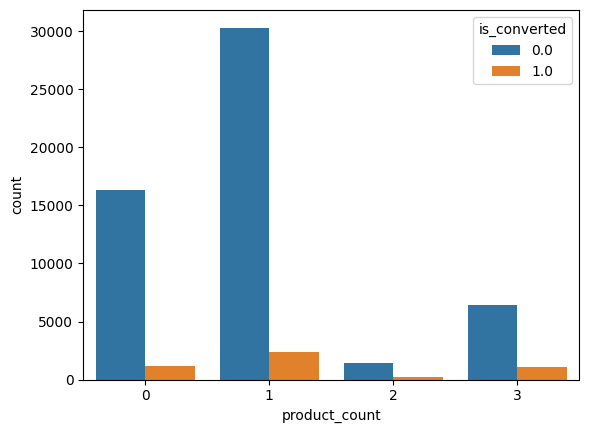

In [32]:
sns.countplot(x = 'product_count', hue = 'is_converted', data = df_all)

### expected_timeline

In [33]:
# expected_timeline
df_all['expected_timeline'].value_counts().head(10)

expected_timeline
less than 3 months     18984
3 months ~ 6 months     5452
more than a year        3295
9 months ~ 1 year       1365
6 months ~ 9 months     1265
less than 6 months       108
etc.                      95
less_than_3_months        76
being followed up         66
being followed up.        24
Name: count, dtype: int64

In [34]:
# '_' -> 공백으로 처리
df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('_', ' ')

In [35]:
# 가장 많이 등장하는 데이터들 제외하고 단어 빈도수
delete_data = ['less than 3 months','3 months ~ 6 months','more than a year','9 months ~ 1 year',
               '6 months ~ 9 months','less than 6 months']

In [38]:
# 성공일 때 가장 많이 보이는 단어
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords

In [39]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hewo1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hewo1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hewo1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [40]:
# null값 unknown
df_all['expected_timeline'] = df_all['expected_timeline'].fillna('unknown')
df_train['expected_timeline'] = df_train['expected_timeline'].fillna('unknown')

In [41]:
# 명사와 동사만 남기는 전처리
def text_clean(text):
  tokens = word_tokenize(text)
  # 불용어 제거
  stop_word = set(stopwords.words('english'))
  tokens = [t for t in tokens if t not in stop_word]
  pos_tags = pos_tag(tokens)

  nouns = [word for word, pos in pos_tags if pos.startswith('N')]
  verbs = [word for word, pos in pos_tags if pos.startswith('V')]

  all = nouns + verbs

  return all


In [42]:
# 실패/성공에 대한 결과가 있어야 하므로 train만 적용
# 영업전환 실패한 고객들의 timeline
timeline_f = []
for i in df_train[df_train['is_converted'] == False]['expected_timeline']:
  if i not in delete_data:
    text = text_clean(i)
    timeline_f.extend(text)

# 영업전환 성공한 고객들의 timeline
timeline_t = []
for i in df_train[df_train['is_converted']]['expected_timeline']:
  if i not in delete_data:
    text = text_clean(i)
    timeline_t.extend(text)

In [43]:
from collections import Counter
count_f = Counter(timeline_f).most_common()
count_f = pd.DataFrame(count_f, columns = ['word', 'count'])

count_t = Counter(timeline_t).most_common()
count_t = pd.DataFrame(count_t, columns = ['word', 'count'])
count_t

,word,count
0,demo,33
1,client,27
2,customer,24
3,shared,21
4,details,17
...,...,...
183,september,1
184,october,1
185,november,1
186,stretch,1


In [44]:
# 가장 빈도수 높은 단어 10개(실패)
dic_ex_f = count_f.head(10).set_index('word').to_dict()['count']
dic_ex_f

{'client': 118,
 'details': 100,
 'etc': 95,
 'followed': 88,
 'requirement': 72,
 'shared': 64,
 'system': 59,
 'customer': 50,
 'hence': 47,
 'call': 44}

In [45]:
# 가장 빈도수 높은 단어 10개(성공)
# unknown 제외
dic_ex = count_t.head(10).set_index('word').to_dict()['count']
dic_ex

{'demo': 33,
 'client': 27,
 'customer': 24,
 'shared': 21,
 'details': 17,
 'call': 12,
 'send': 11,
 'discussed': 11,
 'quote': 10,
 'followed': 10}

In [46]:
# top10 단어들로 가중치 주기
dic_ex_f['client'] = -10
dic_ex_f['details'] = -9
dic_ex_f['etc'] = -8
dic_ex_f['followed'] = -7
dic_ex_f['requirement'] = -6
dic_ex_f['shared'] = -5
dic_ex_f['system'] = -4
dic_ex_f['customer'] = -3
dic_ex_f['hence'] = -2
dic_ex_f['call'] = -1

dic_ex['demo'] = 10
dic_ex['client'] = 9
dic_ex['customer'] = 8
dic_ex['shared'] = 7
dic_ex['details'] = 6
dic_ex['call'] = 5
dic_ex['send'] = 4
dic_ex['discussed'] = 3
dic_ex['quote'] = 2
dic_ex['followed'] = 1

In [47]:
dic_all = {}

for key, value in dic_ex_f.items():
  dic_all[key] = value

for key, value in dic_ex.items():
  dic_all[key] = dic_all.get(key, 0) + value

In [48]:
dic_all

{'client': -1,
 'details': -3,
 'etc': -8,
 'followed': -6,
 'requirement': -6,
 'shared': 2,
 'system': -4,
 'customer': 5,
 'hence': -2,
 'call': 4,
 'demo': 10,
 'send': 4,
 'discussed': 3,
 'quote': 2}

In [60]:
# 하나로 합치기
# dic_all = dic_ex.update(dic_ex_f)

# 단어가 들어있는 비중에 따라 가중치
df_all['timeline_count'] = ''
for i, row in df_all.iterrows():
  score = 0
  if row['expected_timeline'] == 'unknown':
    pass
  else:
    for key in dic_all.keys():
      if key in row['expected_timeline']:
        score += dic_all[key]

  # df_all['timeline_count'][i] = score
  df_all.loc[i, 'timeline_count'] = score

<Axes: xlabel='is_converted', ylabel='count'>

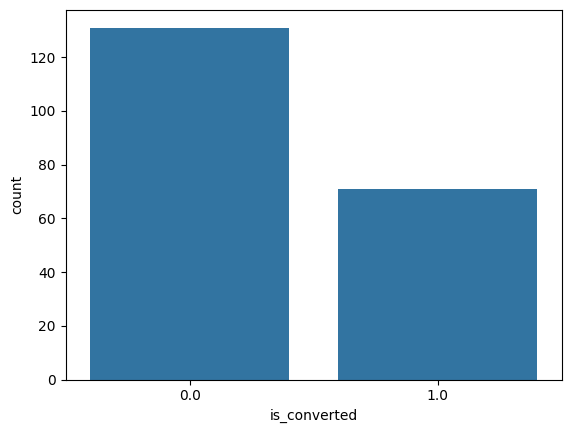

In [62]:
# 양수인 데이터들의 is_converted 비율
ex = df_all[df_all['timeline_count']> 0]
sns.countplot(x = 'is_converted', data = ex)

<Axes: xlabel='is_converted', ylabel='count'>

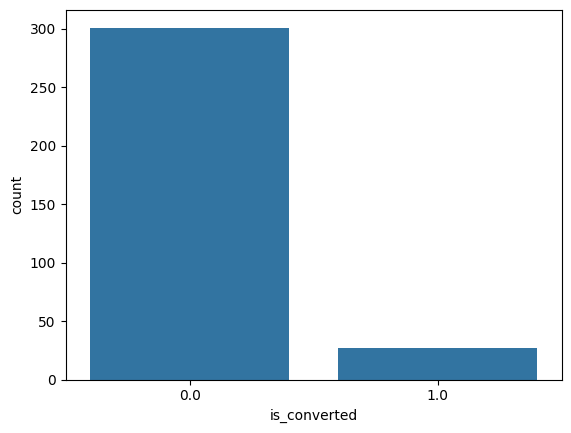

In [63]:
# 음수인 데이터들의 is_converted 비율
ex = df_all[df_all['timeline_count']< 0]
sns.countplot(x = 'is_converted', data = ex)

In [64]:
delete_data

['less than 3 months',
 '3 months ~ 6 months',
 'more than a year',
 '9 months ~ 1 year',
 '6 months ~ 9 months',
 'less than 6 months']

In [65]:
# delete_data를 제외한 나머지는 모두 0으로 처리
# 모두 20개 이하로 매우 적음
df_all['expected_timeline'].value_counts().head(20)

expected_timeline
unknown                                                                                                               33271
less than 3 months                                                                                                    18984
3 months ~ 6 months                                                                                                    5452
more than a year                                                                                                       3295
9 months ~ 1 year                                                                                                      1365
6 months ~ 9 months                                                                                                    1265
less than 6 months                                                                                                      108
etc.                                                                                                              

In [66]:
df_all.loc[~df_all['expected_timeline'].isin(delete_data), 'expected_timeline'] = 0

### historical_existing_cnt(필요)
- 0/1/결측치별 확인 필요

In [67]:
# 결측치 개수
df_all['historical_existing_cnt'].isnull().sum()

49539

In [68]:
df_train[['historical_existing_cnt', 'is_converted']].head(10)

,historical_existing_cnt,is_converted
0,NaN,True
1,12.0,True
2,144.0,True
3,NaN,True
4,NaN,True
5,NaN,True
6,NaN,True
7,NaN,True
8,3.0,True
9,NaN,True


In [69]:
df_train.loc[df_train['is_converted']==True, ['historical_existing_cnt']]

,historical_existing_cnt
0,NaN
1,12.0
2,144.0
3,NaN
4,NaN
...,...
59156,NaN
59161,NaN
59162,NaN
59163,NaN


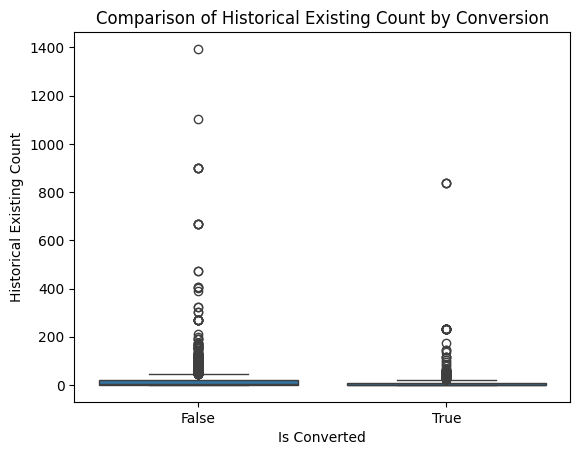

In [70]:
# 영업전환 여부에 따른 영업성공 횟수 비교
sns.boxplot(x='is_converted', y='historical_existing_cnt', data=df_train)
plt.xlabel('Is Converted')
plt.ylabel('Historical Existing Count')
plt.title('Comparison of Historical Existing Count by Conversion')
plt.show()

In [71]:
df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].fillna(0)

### customer_job(필요)

In [72]:
# other 통일
df_all.loc[df_all['customer_job'].str.contains('other', na = False), 'customer_job'] = 'others'

# '_' 공백으로 변경
df_all['customer_job'] = df_all['customer_job'].str.replace('_', ' ')

# null값 0으로 처리
df_all['customer_job'] = df_all['customer_job'].fillna('others')

In [73]:
# other 통일
df_train.loc[df_train['customer_job'].str.contains('other', na = False), 'customer_job'] = 'others'

# '_' 공백으로 변경
df_train['customer_job'] = df_train['customer_job'].str.replace('_', ' ')

# null값 0으로 처리
df_train['customer_job'] = df_train['customer_job'].fillna('others')

In [74]:
df_all['customer_job'].unique()

array(['purchasing', 'media and communication', 'engineering',
       'entrepreneurship', 'consulting', 'program and project management',
       'sales', 'others', 'operations', 'administrative',
       'business development', 'information technology', 'accounting',
       'education', 'healthcare services', 'human resources', 'support',
       'finance', 'marketing', 'legal', 'quality assurance',
       'arts and design', 'real estate',
       'military and protective services', 'research',
       'product management', 'bidder', 'community and social services',
       'research/install', 'project manager', 'technical', 'details send',
       'architect', 'curation', 'developer/property',
       'radiology professional', 'graphic/color art',
       'medical imaging specialist', 'medical solution provider',
       'manager', 'owner', 'designer', 'recommend',
       'consultant / purchaser', 'system installer',
       'technical advisor, reseller', 'director it', 'execution',
       'own

In [75]:
df_test['customer_job'].unique()

array(['consulting', nan, 'information technology', 'sales',
       'engineering', 'marketing', 'purchasing', 'others', 'operations',
       'support', 'finance', 'business development', 'administrative',
       'education', 'product management',
       'program and project management', 'entrepreneurship',
       'community and social services', 'media and communication',
       'arts and design', 'healthcare services', 'accounting',
       'medical imaging specialist', 'clinical specialist', 'curation',
       'other', '3d/vfx art', 'legal', 'radiology professional',
       'military and protective services', 'real estate',
       'human resources', 'healthcare', 'electronics & telco',
       'quality assurance', 'pathologist', 'research',
       'surgery professional', 'film production', 'k12 school',
       'media and communications', 'medical solution provider'],
      dtype=object)

In [76]:
def job_categorize(text):
  if 'accounting' in text:
    return 'accounting'
  elif 'administrative' in text:
    return 'administrative'
  elif 'arts and design' in text:
    return 'arts and design'
  elif 'business development' in text:
    return 'business development'
  elif 'community and social services' in text:
    return 'community and social services'
  elif 'consulting' in text:
    return 'consulting'
  elif 'curation' in text:
    return 'curation'
  elif 'education' in text:
    return 'education'
  elif 'engineering' in text:
    return 'engineering'
  elif 'entrepreneurship' in text:
    return 'entrepreneurship'
  elif 'finance' in text:
    return 'finance'
  elif 'healthcare services' in text:
    return 'healthcare services'
  elif 'human resources' in text:
    return 'human resources'
  elif 'information technology' in text:
    return 'information technology'
  elif 'legal' in text:
    return 'legal'
  elif 'marketing' in text:
    return 'marketing'
  elif 'media and communication' in text:
    return 'media and communication'
  elif 'military and protective services' in text:
    return 'military and protective services'
  elif 'operations' in text:
    return 'operations'
  elif 'product management' in text:
    return 'product management'
  elif 'program and project management' in text:
    return 'program and project management'
  elif 'purchasing' in text:
    return 'purchasing'
  elif 'quality assurance' in text:
    return 'quality assurance'
  elif 'real estate' in text:
    return 'real estate'
  elif 'research' in text:
    return 'research'
  elif 'sales' in text:
    return 'sales'
  elif 'support' in text:
    return 'support'
  else:
    return 'other'

In [77]:
df_train['customer_job'] = df_train['customer_job'].apply(job_categorize)
df_train['customer_job'].unique()

array(['purchasing', 'media and communication', 'engineering',
       'entrepreneurship', 'consulting', 'program and project management',
       'sales', 'other', 'operations', 'administrative',
       'business development', 'information technology', 'accounting',
       'education', 'healthcare services', 'human resources', 'support',
       'finance', 'marketing', 'legal', 'quality assurance',
       'arts and design', 'real estate',
       'military and protective services', 'research',
       'product management', 'community and social services', 'curation'],
      dtype=object)

In [78]:
# 각 직업별로 True의 수 계산
true_counts = df_train[df_train['is_converted']].groupby('customer_job').size()

# True의 수를 기준으로 내림차순 정렬하여 순위 메김
true_counts_ranked = true_counts.sort_values(ascending=False)

# 결과 출력
print(true_counts_ranked)

customer_job
other                               1859
engineering                          572
information technology               330
administrative                       324
purchasing                           271
education                            204
business development                 177
sales                                141
operations                           131
consulting                           130
marketing                            123
entrepreneurship                     108
arts and design                       85
program and project management        77
healthcare services                   64
media and communication               52
real estate                           48
accounting                            36
finance                               34
support                               23
product management                    19
human resources                       11
research                              11
military and protective services       8
com

In [79]:
# 각 직업별로 False의 수 계산
false_counts = df_train[~df_train['is_converted']].groupby('customer_job').size()

# False의 수를 기준으로 내림차순 정렬하여 순위 메김
false_counts_ranked = false_counts.sort_values(ascending=False)

# 결과 출력
print(false_counts_ranked)

customer_job
other                               25376
engineering                          5794
administrative                       3038
sales                                2090
education                            2086
operations                           1845
purchasing                           1676
business development                 1629
information technology               1622
consulting                           1219
arts and design                      1200
entrepreneurship                     1084
marketing                            1054
program and project management        884
media and communication               659
healthcare services                   572
product management                    555
finance                               431
accounting                            360
support                               339
real estate                           247
legal                                 153
research                              137
community and social 

C:\Users\hewo1\AppData\Local\Temp\ipykernel_16004\3135664363.py:23: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\hewo1\AppData\Local\Temp\ipykernel_16004\3135664363.py:23: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\hewo1\AppData\Local\Temp\ipykernel_16004\3135664363.py:23: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\hewo1\AppData\Local\Temp\ipykernel_16004\3135664363.py:23: UserWarning: Glyph 51649 (\N{HANGUL SYLLABLE JIG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\hewo1\AppData\Local\Temp\ipykernel_16004\3135664363.py:23: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
c:\Users\hewo1\miniconda3\envs\b2best\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4425

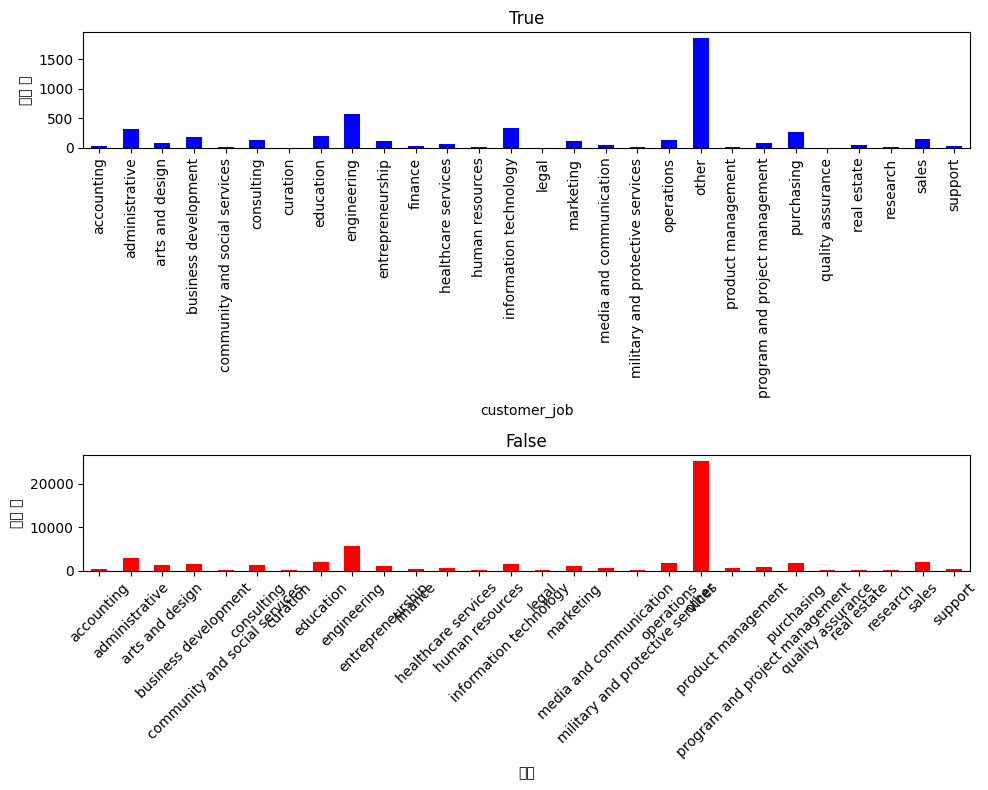

In [80]:
# 각 직업별로 True와 False의 수 계산
job_counts = df_train.groupby('customer_job')['is_converted'].value_counts().unstack(fill_value=0)

# True와 False의 막대 그래프를 따로 그리기 위해 데이터 분리
true_data = job_counts[True]
false_data = job_counts[False]

# True/False (분모 0이면 1로)

# 막대 그래프로 시각화
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

true_data.plot(kind='bar', ax=ax[0], color='blue', legend=False)
ax[0].set_title('True')
ax[0].set_ylabel('고객 수')

false_data.plot(kind='bar', ax=ax[1], color='red', legend=False)
ax[1].set_title('False')
ax[1].set_ylabel('고객 수')

plt.xlabel('직업')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

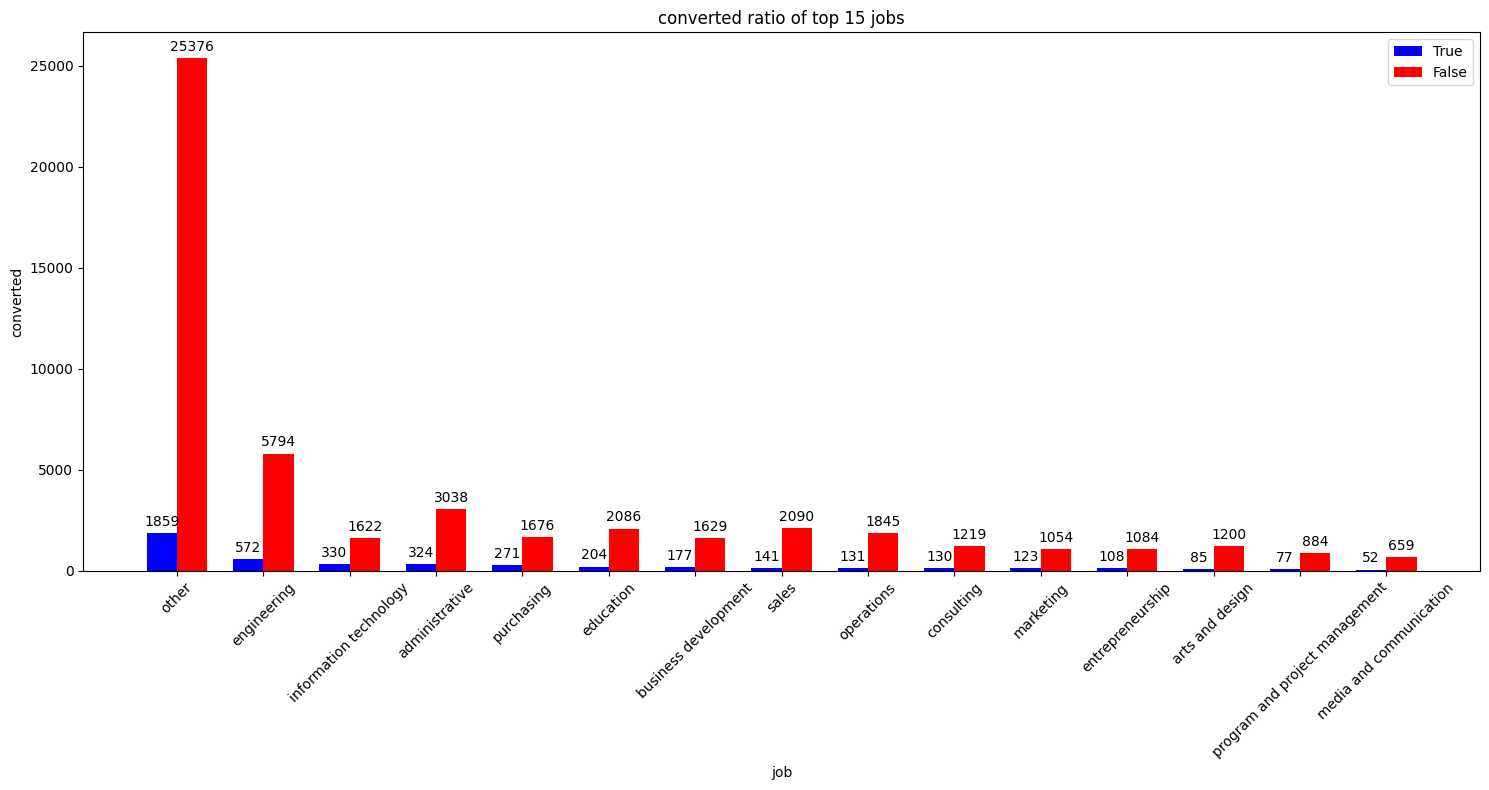

In [81]:
# 상위 15개 직업 선택
top_15_jobs = job_counts.sum(axis=1).nlargest(15).index

# 선택된 상위 15개 직업에 대해서만 데이터 추출
top_15_data = job_counts.loc[top_15_jobs]

# True가 많은 순으로 정렬
top_15_data_sorted = top_15_data.sort_values(by=True, ascending=False)

# 막대 그래프를 옆으로 그리기 위해 위치 설정
ind = np.arange(len(top_15_data_sorted.index))
width = 0.35

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 8))

true_bars = ax.bar(ind - width/2, top_15_data_sorted[True], width, label='True', color='blue')
false_bars = ax.bar(ind + width/2, top_15_data_sorted[False], width, label='False', color='red')

# 레이블 및 타이틀 설정
ax.set_xlabel('job')
ax.set_ylabel('converted')
ax.set_title('converted ratio of top 15 jobs')
ax.set_xticks(ind)
ax.set_xticklabels(top_15_data_sorted.index, rotation=45)
ax.legend()

# 막대 위에 값 표시
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(true_bars)
autolabel(false_bars)

plt.tight_layout()
plt.show()

### customer_type

In [82]:
df_all['customer_type'].value_counts()

customer_type
End-Customer                    6648
End Customer                    6449
Specifier/ Influencer           3313
Channel Partner                 1695
Service Partner                  447
Solution Eco-Partner             292
Installer/Contractor              52
Specifier / Influencer            43
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         18
Technician                        16
Consultant                        15
Other                             10
Home Owner                        10
End-user                           8
Manager / Director                 8
Software/Solution Provider         7
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Reseller                           5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                  

In [83]:
df_all[df_all['is_converted'] == True]['customer_type'].value_counts()

customer_type
End-Customer              757
End Customer              711
Specifier/ Influencer     189
Channel Partner           166
Service Partner            49
Solution Eco-Partner       43
Specifier / Influencer     15
Consultant                 11
Installer                   5
Homeowner                   3
Others                      2
Architect/Consultant        2
Installer/Contractor        1
Name: count, dtype: int64

In [89]:
# '-' 제거 및 '/' -> ','으로 처리
df_all['customer_type'] = df_all['customer_type'].str.replace('-', ' ')
df_all['customer_type'] = df_all['customer_type'].str.replace('/', ',')

# ',' 뒤에만 공백이 남도록 전처리
df_all['customer_type'] = df_all['customer_type'].apply(lambda x: re.sub(r'\s*,\s*', ', ', x) if isinstance(x, str) else x)

In [90]:
# other 통일
df_all.loc[df_all['customer_type'].str.contains('Other', na = False), 'customer_type'] = 'other'

# etc도 other로 통일
df_all['customer_type'] = df_all['customer_type'].str.replace('Etc.', 'other')

# homeowner 통일
df_all.loc[df_all['customer_type'].str.contains('Home', na = False), 'customer_type'] = 'Homeowner'

In [91]:
# 1. null값 모두 other로 변경해서 처리
df_all['customer_type'] = df_all['customer_type'].fillna('other')

In [92]:
# other를 0으로 전처리
df_all['customer_type'] = df_all['customer_type'].replace('other', 0)

In [93]:
df_all['customer_type'].value_counts()

customer_type
0                              45438
End Customer                   13097
Specifier, Influencer           3356
Channel Partner                 1695
Service Partner                  447
Solution Eco Partner             292
Installer, Contractor             52
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         18
Technician                        16
Consultant                        15
Homeowner                         15
Software, Solution Provider        8
Manager, Director                  8
End user                           8
Architect, Consultant              5
Installer                          5
Interior Designer                  5
Reseller                           5
Distributor                        4
Dealer, Distributor                2
System Integrator                  2
Technical Assistant                1
Commercial end user                1
Administrator           

In [94]:
# installer -> installer, contractor
df_all.loc[df_all['customer_type'].str.contains('Installer', na = False), 'customer_type'] = 'Installer, Contractor'

# distributor -> dealer, distributor
df_all.loc[df_all['customer_type'].str.contains('Distributor', na = False), 'customer_type'] = 'Dealer, Distributor'

# consultant -> architect, consultant
df_all.loc[df_all['customer_type'].str.contains('Consultant', na = False), 'customer_type'] = 'Architect, Consultant'

In [95]:
df_all['customer_type'].value_counts()

customer_type
0                              45438
End Customer                   13097
Specifier, Influencer           3356
Channel Partner                 1695
Service Partner                  447
Solution Eco Partner             292
Installer, Contractor             57
Corporate                         31
HVAC Engineer                     23
Architect, Consultant             20
Engineer                          20
Developer                         18
Technician                        16
Homeowner                         15
Manager, Director                  8
End user                           8
Software, Solution Provider        8
Dealer, Distributor                6
Reseller                           5
Interior Designer                  5
System Integrator                  2
Technical Assistant                1
Commercial end user                1
Administrator                      1
Name: count, dtype: int64

In [96]:
# customer_type 종류 중 is_converted의 값을 false만 가지는 것
# 얘네를 하나로 통일
df_all.groupby('customer_type').filter(lambda x: not x['is_converted'].any())['customer_type'].unique()

array(['Corporate', 'Dealer, Distributor', 'System Integrator',
       'Technician', 'Engineer', 'Manager, Director', 'Developer',
       'End user', 'HVAC Engineer', 'Reseller',
       'Software, Solution Provider', 'Technical Assistant',
       'Commercial end user', 'Interior Designer', 'Administrator'],
      dtype=object)

In [97]:
# customer_type 종류 중 is_converted의 값을 true만 가지는 것
# 원래 installer는 true만 있었는데 위에서 합쳐서 없는것으로 나오게 됨
df_all.groupby('customer_type').filter(lambda x: x['is_converted'].all())['customer_type'].unique()

array([], dtype=object)

In [98]:
# 종류 별 is_converted 열에서 true의 값 개수
df_all[df_all['is_converted'] == True]['customer_type'].value_counts()

customer_type
0                        2898
End Customer             1468
Specifier, Influencer     204
Channel Partner           166
Service Partner            49
Solution Eco Partner       43
Architect, Consultant      13
Installer, Contractor       6
Homeowner                   3
Name: count, dtype: int64

In [99]:
# 결측치, oters, etc => 0
# 0 : false의 양이 많
df_all[df_all['is_converted'] == False]['customer_type'].value_counts()

customer_type
0                              41083
End Customer                    9175
Specifier, Influencer           2364
Channel Partner                 1202
Service Partner                  300
Solution Eco Partner             103
Installer, Contractor             51
Corporate                         31
HVAC Engineer                     23
Engineer                          20
Developer                         17
Technician                        16
Homeowner                         12
Manager, Director                  8
End user                           8
Software, Solution Provider        8
Architect, Consultant              7
Dealer, Distributor                6
Reseller                           5
Interior Designer                  5
System Integrator                  2
Technical Assistant                1
Commercial end user                1
Administrator                      1
Name: count, dtype: int64

In [100]:
# 위에 false만 있는 값을 모두 모아 1로 묶음
df_all['customer_type'] = df_all['customer_type'].replace(['Corporate', 'Dealer, Distributor', 'System Integrator', 'Technician', 'Engineer', 'Manager, Director', 'Developer', 'End user', 'HVAC Engineer', 'Reseller', 'Software, Solution Provider', 'Technical Assistant', 'Commercial end user', 'Interior Designer', 'Administrator'], 1)

In [101]:
df_all['customer_type'].value_counts()

customer_type
0                        45438
End Customer             13097
Specifier, Influencer     3356
Channel Partner           1695
Service Partner            447
Solution Eco Partner       292
1                          153
Installer, Contractor       57
Architect, Consultant       20
Homeowner                   15
Name: count, dtype: int64

### id, it, idit_strategic_ver

In [102]:
# 이건 모두 null값 0으로 처리
columns = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']

for col in columns:
   df_all[col] = df_all[col].fillna(0)

In [103]:
df_all['id_strategic_ver'].value_counts()

id_strategic_ver
0.0    60533
1.0     4037
Name: count, dtype: int64

In [104]:
df_all['it_strategic_ver'].value_counts()

it_strategic_ver
0.0    63396
1.0     1174
Name: count, dtype: int64

In [105]:
df_all['idit_strategic_ver'].value_counts()

idit_strategic_ver
0.0    59359
1.0     5211
Name: count, dtype: int64

In [106]:
 # id, it 같이 안가지는 지 확인
df_all[(df_all['it_strategic_ver'] == 1) & (df_all['id_strategic_ver'] == 1)].shape[0]

0

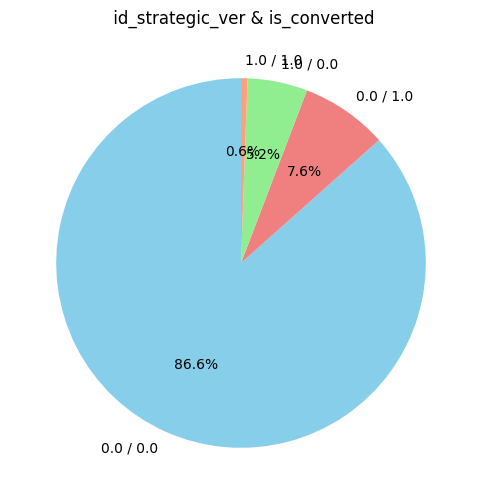

In [107]:
# 'id_strategic_ver'와 'is_converted' 열을 이용하여 새로운 DataFrame 생성
count_df = df_all.fillna({'id_strategic_ver': 0}).groupby(['id_strategic_ver', 'is_converted']).size().reset_index(name='count')

# 원 그래프 그리기
plt.figure(figsize=(6, 6))
plt.pie(count_df['count'], labels=count_df.apply(lambda x: f"{x['id_strategic_ver']} / {x['is_converted']}", axis=1),
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'])

plt.title(' id_strategic_ver & is_converted')
plt.show()

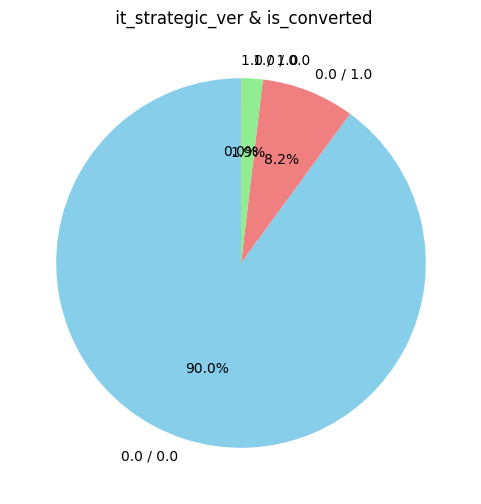

In [108]:
# 'it_strategic_ver'와 'is_converted' 열을 이용하여 새로운 DataFrame 생성
count_df = df_all.fillna({'it_strategic_ver': 0}).groupby(['it_strategic_ver', 'is_converted']).size().reset_index(name='count')

# 원 그래프 그리기
plt.figure(figsize=(6, 6))
plt.pie(count_df['count'], labels=count_df.apply(lambda x: f"{x['it_strategic_ver']} / {x['is_converted']}", axis=1),
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'])

plt.title(' it_strategic_ver & is_converted')
plt.show()

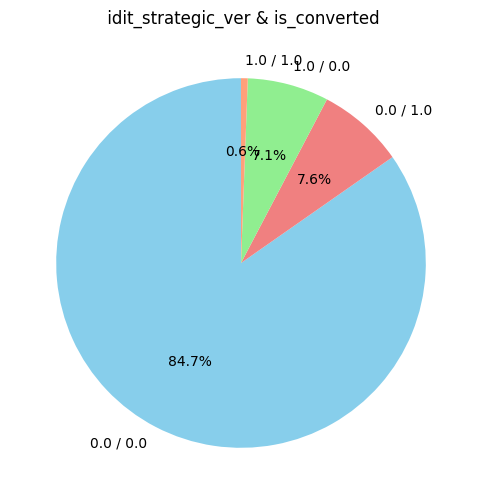

In [109]:
# 'idit_strategic_ver'와 'is_converted' 열을 이용하여 새로운 DataFrame 생성
count_df = df_all.fillna({'idit_strategic_ver': 0}).groupby(['idit_strategic_ver', 'is_converted']).size().reset_index(name='count')

# 원 그래프 그리기
plt.figure(figsize=(6, 6))
plt.pie(count_df['count'], labels=count_df.apply(lambda x: f"{x['idit_strategic_ver']} / {x['is_converted']}", axis=1),
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'])

plt.title(' idit_strategic_ver & is_converted')
plt.show()

In [110]:
# idit_all : id = 1, it =2, 결측치 = 0

# 'idit_all' 열 초기화
df_all['idit_all'] = 0

# 'id_strategic_ver'에서 1 -> 1
df_all.loc[df_all['id_strategic_ver'] == 1, 'idit_all'] = 1

# 'it_strategic_ver'에서 1 -> 2
df_all.loc[df_all['it_strategic_ver'] == 1, 'idit_all'] = 2

# 나머지는 0으로 저장
df_all['idit_all'].fillna(0)

0        0
1        0
2        0
3        0
4        0
        ..
64565    0
64566    0
64567    0
64568    0
64569    0
Name: idit_all, Length: 64570, dtype: int64

In [111]:
df_all['idit_all'].value_counts()

idit_all
0    59359
1     4037
2     1174
Name: count, dtype: int64

In [112]:
# id_strategic_ver, it_strategic_ver, idit_strategic_ver 드롭
df_all.drop(columns=['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], inplace=True)

### customer_country

In [113]:
# null값은 모두 'unknown'으로 전처리
# 추후에 다시 0으로 처리
df_all['customer_country'] = df_all['customer_country'].fillna('unknown')
df_all['customer_country'] = df_all['customer_country'].str.lower()
# '/' 기준 분리 후 맨 뒤를 국적으로 별도 변수 생성
def country_split(text):
  text = text.split('/')
  return text[-1]
country_list = df_all['customer_country'].apply(country_split)
# 공백 제거
country_list = country_list.str.strip()

In [114]:
# 20개 이상 국가만 사용: 550 -> 83
country_list = list(country_list.value_counts()[:83].index)
country_list.remove('')
# indianapolis 는 US 도시
country_list.remove('india')
country_list.append('india')

In [115]:
def preprocess_country(text):
    # 나라 이름으로 전처리
    for country in list(country_list):
      if country in text:
        # print(country, text)
        return country
    return 'other'

# 'customer_country' 열에 대해 전처리 적용
df_all['customer_country'] = df_all['customer_country'].apply(preprocess_country)

### inquiry_type

In [116]:
# 데이터를 문자열로 변환하는 함수
def convert_to_string(value):
    return str(value) if value is not None else ''

def preprocess_inquiry(text):
    # 문자열로 변환
    text = convert_to_string(text)

    # 소문자로 변환
    text = text.lower()

    # 특수 문자 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 중복된 값 처리
    if 'technical' in text and text != 'technical support':
        return 'technical'
    if 'quotation' in text:
        return 'quotation'
    if 'sales' in text:
        return 'sales'
    if 'other' in text or 'etc' in text:
        return 'other'
    for inquiry in ['customer suggestions', 'nan', 'technical support', 'partnership', 'distributorship', 'demo', 'services', 'product information', 'trainings']:
        if inquiry in text:
            return text
    return 'others'

# 'inquiry_type' 열에 대해 전처리 적용
df_all['inquiry_type'] = df_all['inquiry_type'].apply(preprocess_inquiry)